In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_theme()

In [3]:
from scipy.stats import betabinom
from random import random
from tqdm.notebook import tqdm

In [4]:
df_ref = pd.read_csv('./Data/glioblastoma_BT_S2/ref.csv', index_col = 0)
df_alt = pd.read_csv('./Data/glioblastoma_BT_S2/alt.csv', index_col = 0)

In [5]:
# use multi-index for easier handling of the data
df_ref['chromosome'] = [locus.split('_')[0] for locus in df_ref.index]
df_ref['locus'] = [locus.split('_')[1] for locus in df_ref.index]
df_ref = df_ref.set_index(['chromosome', 'locus'])

df_alt['chromosome'] = [locus.split('_')[0] for locus in df_alt.index]
df_alt['locus'] = [locus.split('_')[1] for locus in df_alt.index]
df_alt = df_alt.set_index(['chromosome', 'locus'])

In [6]:
df_ref

SRR3934349  SRR3934350  SRR3934351  SRR3934352  \
chromosome locus                                                       
chr1       629782             62           0           9          25   
           631861              0           0           6           5   
           633792             92          30          40         138   
           633801             94          27          37         139   
           634233              4           0           2           3   
...                          ...         ...         ...         ...   
chrX       154778966           0           0           0           0   
           154801469           0           0           0           0   
           155051675           0           0          47          47   
           155061890           0           0           8          32   
           155943589           0           0           0           3   

                      SRR3934353  SRR3934354  SRR3934355  SRR3934356  \
chromosome locus                                                       
chr1       629782             20          71          13          10   
           631861             15          36           2           6   
           633792            308         342          17          46   
           633801            301         330          17          46   
           634233             16           9           0           0   
...                          ...         ...         ...         ...   
chrX       154778966           0          34           1           0   
           154801469           0           0           0           0   
           155051675           0           0          17           0   
           155061890           0           0           9           0   
           155943589           0           0           4           0   

                      SRR3934357  SRR3934358  ...  SRR3935507  SRR3935508  \
chromosome locus                              ...                           
chr1       629782             29           0  ...           6           2   
           631861             11           0  ...           0          21   
           633792            151           0  ...          73          43   
           633801            140           0  ...          75          42   
           634233              3           0  ...           0           0   
...                          ...         ...  ...         ...         ...   
chrX       154778966           0           0  ...           0           0   
           154801469           0           0  ...           0           0   
           155051675           0          22  ...           0          40   
           155061890           0           0  ...           0           0   
           155943589           0           6  ...          16          11   

                      SRR3935509  SRR3935510  SRR3935511  SRR3935512  \
chromosome locus                                                       
chr1       629782              4          20           1           3   
           631861              1           0           0           0   
           633792              9          34           0          23   
           633801              9          33           0          22   
           634233              1           1           0           0   
...                          ...         ...         ...         ...   
chrX       154778966           0           0           0           0   
           154801469           0           0           0           0   
           155051675           0           0           0           0   
           155061890           0           0           0           0   
           155943589           0          19           0          11   

                      SRR3935513  SRR3935514  SRR3935515  SRR3935516  
chromosome locus                                                      
chr1       629782             21          23           3           

In [7]:
def heterozygosity_map(chromosome, save = False):
    ref = np.array(df_ref.loc[chromosome,:])
    alt = np.array(df_alt.loc[chromosome,:])
    
    ref_proportion = (ref + 1) / (ref + alt + 2) # add a dummy count to both ref and alt to avoid division by 0
    alpha = 2 * np.arctan(ref + alt) / np.pi # hide loci without enough counts
    
    plt.figure(figsize=(24,16))
    plt.imshow(ref_proportion.T, cmap = 'viridis', vmin = 0., vmax = 1., alpha = alpha.T) 
    # "viridis": yellow for 1, purple for 0, green/blue for 0.5 (https://matplotlib.org/3.5.1/tutorials/colors/colormaps.html)
    plt.title(chromosome, fontsize = 17)
    plt.xlabel('locus index', fontsize = 17)
    plt.ylabel('cell index', fontsize = 17)
    if save: 
        plt.savefig('chromosome' + '.png')
    plt.show()

In [8]:
# proportion of entries that has at least one read (reference or alternative or both)
np.sum(np.logical_or(np.array(df_ref), np.array(df_alt))) / df_ref.size
# Conclustion: 70% of all entries have no read at all

0.2911500069116471

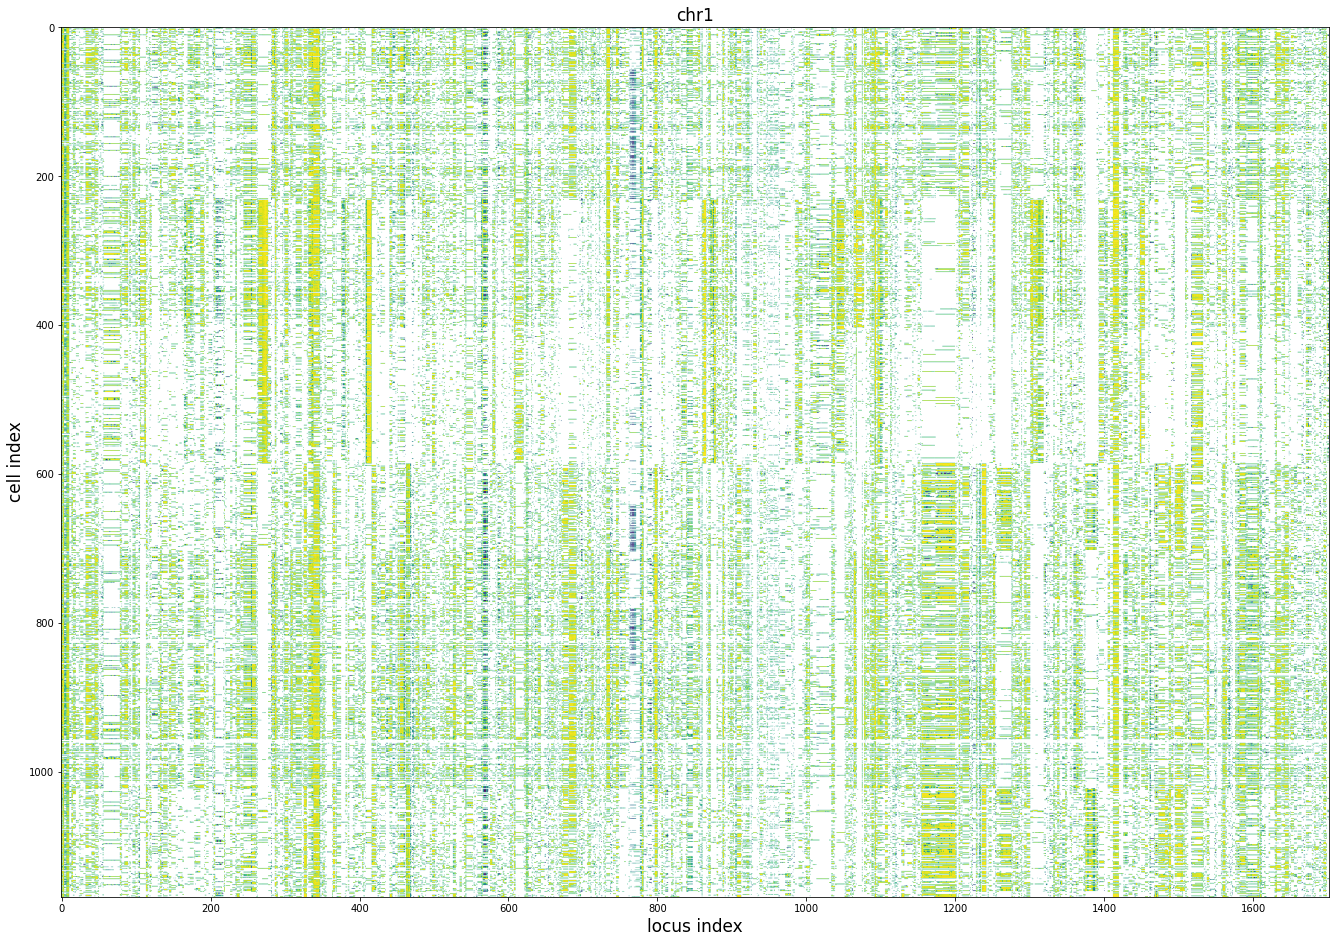

In [9]:
heterozygosity_map('chr1', save = True)

In [10]:
#for chromosome in df_ref.index.get_level_values('chromosome').unique():
#    heterozygosity_map(chromosome)

### Mutation detection

In [11]:
ref = np.array(df_ref.loc['chr1',:], dtype = float)
alt = np.array(df_alt.loc['chr1',:], dtype = float)

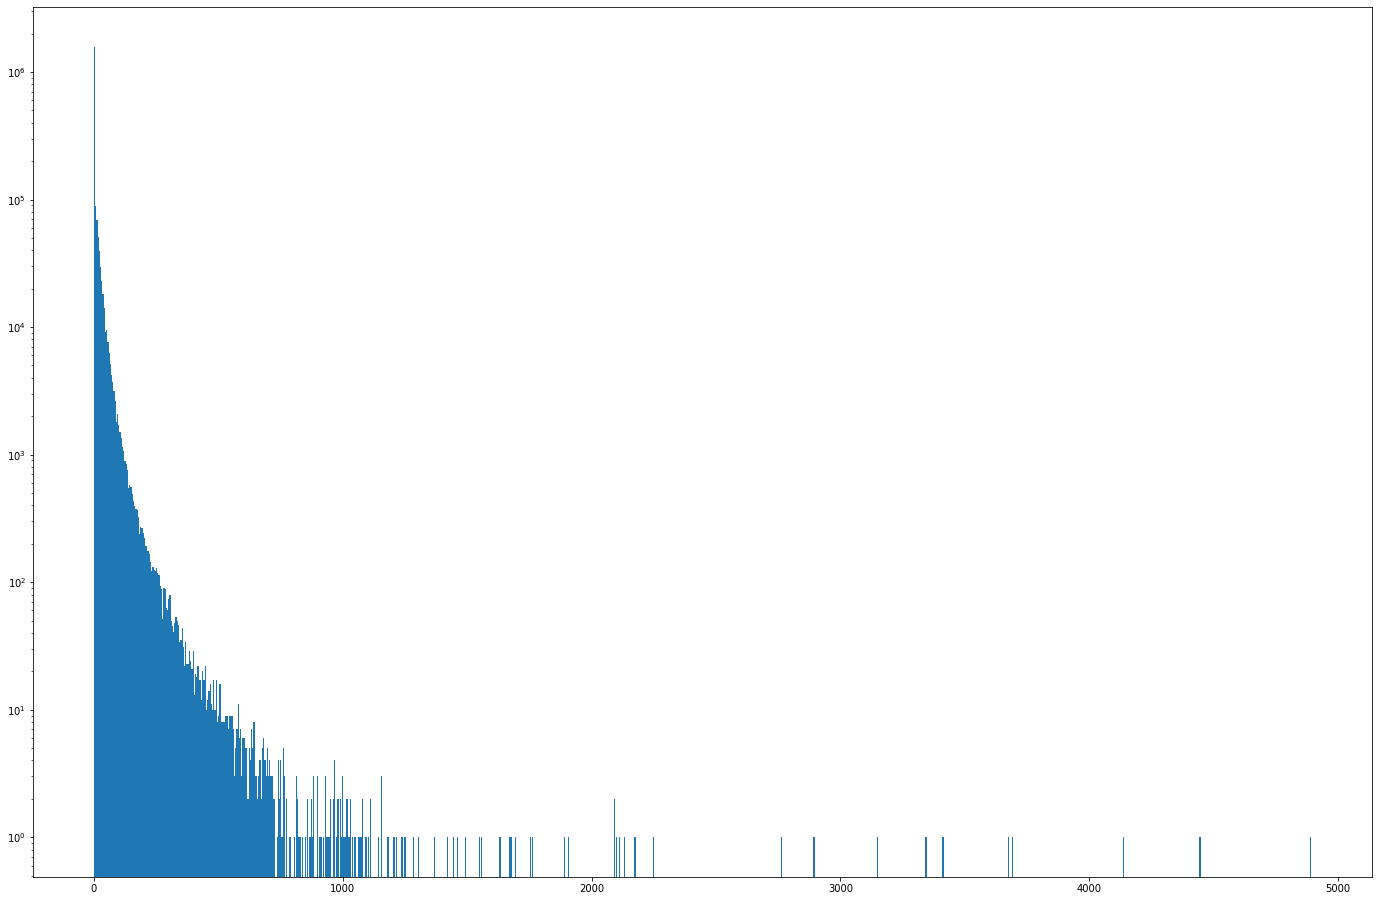

In [11]:
plt.figure(figsize = (24, 16))
plt.hist(ref.flatten(), bins = 1000)
plt.yscale('log')
plt.show()

In [12]:
def probability_genotype(n_ref, n_alt, priors, f = 0.95, omega = 100):
    '''
    Probabilities of the three genotypes (ref only / alt only / heterozygous) of a cell, given its reads on ref and alt
    '''
    coverage = n_ref + n_alt 
    probabilities = np.zeros(3) 
    
    # case 1: ref only
    alpha = f * omega
    beta = omega - alpha
    probabilities[0] = betabinom.pmf(n_ref, coverage, alpha, beta) * priors[0]
    # case 2: alt only
    alpha = (1/3 - f/3) * omega
    beta = omega - alpha
    probabilities[1] = betabinom.pmf(n_ref, coverage, alpha, beta) * priors[1]
    # case 3: heterozygous, use lower overdispersion because of uncertainty in amplification step
    alpha = (1/6 + f/3) * omega/2 
    beta = omega/2 - alpha 
    probabilities[2] = betabinom.pmf(n_ref, coverage, alpha, beta) * priors[2]
    
    # normalize to get posterior
    probabilities = probabilities / np.sum(probabilities)
    
    return probabilities


def mutation_score(ref, alt, priors):
    '''
    minus log-probability that the locus has no mutation (i.e. all cells have the same genotype)
    higher score = mutation more likely
    '''
    log_P = np.zeros(3) 
    
    for i in range(len(ref)): # "add" cells one by one and adjust the probabilities accordingly
        if ref[i] + alt[i] == 0: # ignore cells that have no read at all
            continue
        log_P_i = np.log(probability_genotype(ref[i], alt[i], priors))
        log_P += log_P_i
    
    print(log_P)
    # The three probabilities are often too small and become equal to 0 due to range of float type
    # The following step tries to bypass this issue
    log_P_max = np.max(log_P)
    score = - log_P_max - np.log(np.sum(np.exp(log_P - log_P_max))) 
    return score

In [13]:
prior_estimate = np.zeros(3)
count = 0
for i in tqdm(range(ref.shape[0])):
    for j in range(ref.shape[1]):
        if ref[i,j] + alt[i,j] != 0:
            prior_estimate += probability_genotype(ref[i,j], alt[i,j], priors = np.array([1/3, 1/3, 1/3]))
            count += 1

prior_estimate /= count            
print(prior_estimate)

  0%|          | 0/1702 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [15]:
scores = np.zeros(ref.shape[0])
for i in tqdm(range(ref.shape[0])): 
    scores[i] = mutation_score(ref[i,:], alt[i,:], prior_estimate) 

print(scores)

  0%|          | 0/1702 [00:00<?, ?it/s]

[ 14.46815124 730.45141126   4.91622439 ...  19.22323464   1.89124739
         -inf]


/tmp/ipykernel_4086/2182369980.py:42: RuntimeWarning: overflow encountered in exp
  score = - log_P[0] - np.log(1 + np.exp(log_P[1] - log_P[0]) + np.exp(log_P[2] - log_P[0]))


In [20]:
scores[i] = mutation_score(ref[-1,:], alt[-1,:], prior_estimate) 

[-3028.93681808 -3343.12743942 -1278.25810749]


/tmp/ipykernel_4086/3788384373.py:44: RuntimeWarning: overflow encountered in exp
  score = - log_P[0] - np.log(1 + np.exp(log_P[1] - log_P[0]) + np.exp(log_P[2] - log_P[0]))


In [18]:
np.sum(scores == -np.inf)

69

### LOH detection

### SVD Imputation

In [67]:
# X: data matrix in which rows (dimension 0) are samples and columns (dimension 1) are features
def mean_impute(X): 
    X_imputed = X.copy() 
    for i in range(X.shape[1]): 
        feature = X[:,i] 
        mean = np.nanmean(feature) # take mean of the feature, ignoring NaN
        if np.isnan(mean): 
            print('[Mean Imputation] WARNING: Empty feature at column %d.'%i) 
        nan_indices = np.where(np.isnan(feature))[0] 
        X_imputed[nan_indices,i] = mean 
    return X_imputed 


def zero_impute(X): 
    X_imputed = X.copy()
    X_imputed[np.isnan(X)] = 0
    return X_imputed
    

def svd_impute(X, rank = None, tol = 0.1, max_iter = 100):
    if rank is None: 
        rank = min(X.shape) // 2
    
    nan_indices = np.where(np.isnan(X))
    X_imputed = zero_impute(X) #initialise all nan entries with the a mean imputation
    
    for i in tqdm(range(max_iter)):
        X_old = X_imputed.copy()
        L,D,R = np.linalg.svd(X_imputed)
        X_approx = L[:,:rank] @ np.diag(D[:rank]) @ R[:rank,:] #rank r approximation of X_imputed
        X_imputed[nan_indices] = X_approx[nan_indices]
        fnorm = np.linalg.norm(X_old - X_imputed, ord="fro")
        if fnorm < tol:
            print('[SVD Imputation]: Converged after %d iterations.'%(i+1))
            print('Frobenius norm:', fnorm)
            break
        if (i+1) >= max_iter:
            print('[SVD Imputation]: Maximum number (%d) of iterations reached.'%(i+1))
            print('Frobenius norm:', fnorm)
    
    return X_imputed

In [17]:
ref.shape

(1702, 1168)

In [28]:
np.sum(alt > 5, axis = 1)

array([ 0, 63, 40, ...,  1,  1, 84])

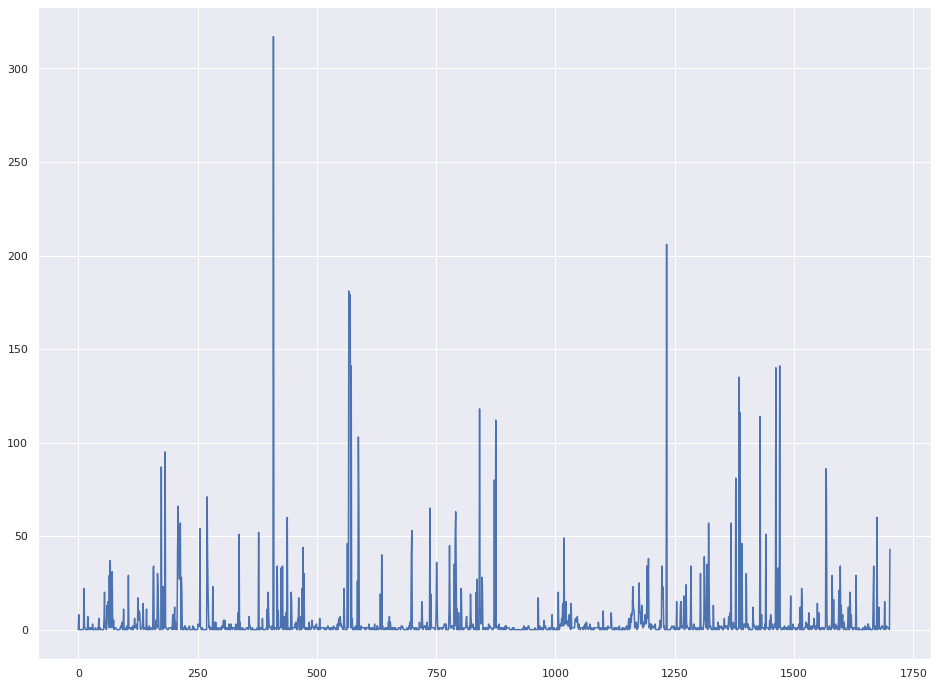

In [32]:
plt.figure(figsize = (16, 12))
plt.plot(np.sum(alt > 16, axis = 1))
plt.show()

In [ ]:
for i in range(ref.shape[0]): 
    for j in range(ref.shape[1]): 
        if ref[i,j] == 0 and alt[i,j] == 0:
            ref[i,j] = np.nan
            alt[i,j] = np.nan

In [73]:
X = np.concatenate([ref, alt], axis = 1)
X_imputed = svd_impute(X, rank = 5)

100%|█████████████████████████████████████████████████████████████| 100/100 [06:03<00:00,  3.63s/it]

[SVD Imputation]: Maximum number (100) of iterations reached.
Frobenius norm: 196.81055642117263


In [74]:
X_imputed.shape

(1702, 2336)

In [75]:
ref_imputed = X_imputed[:,:ref.shape[1]]
alt_imputed = X_imputed[:,ref.shape[1]:]

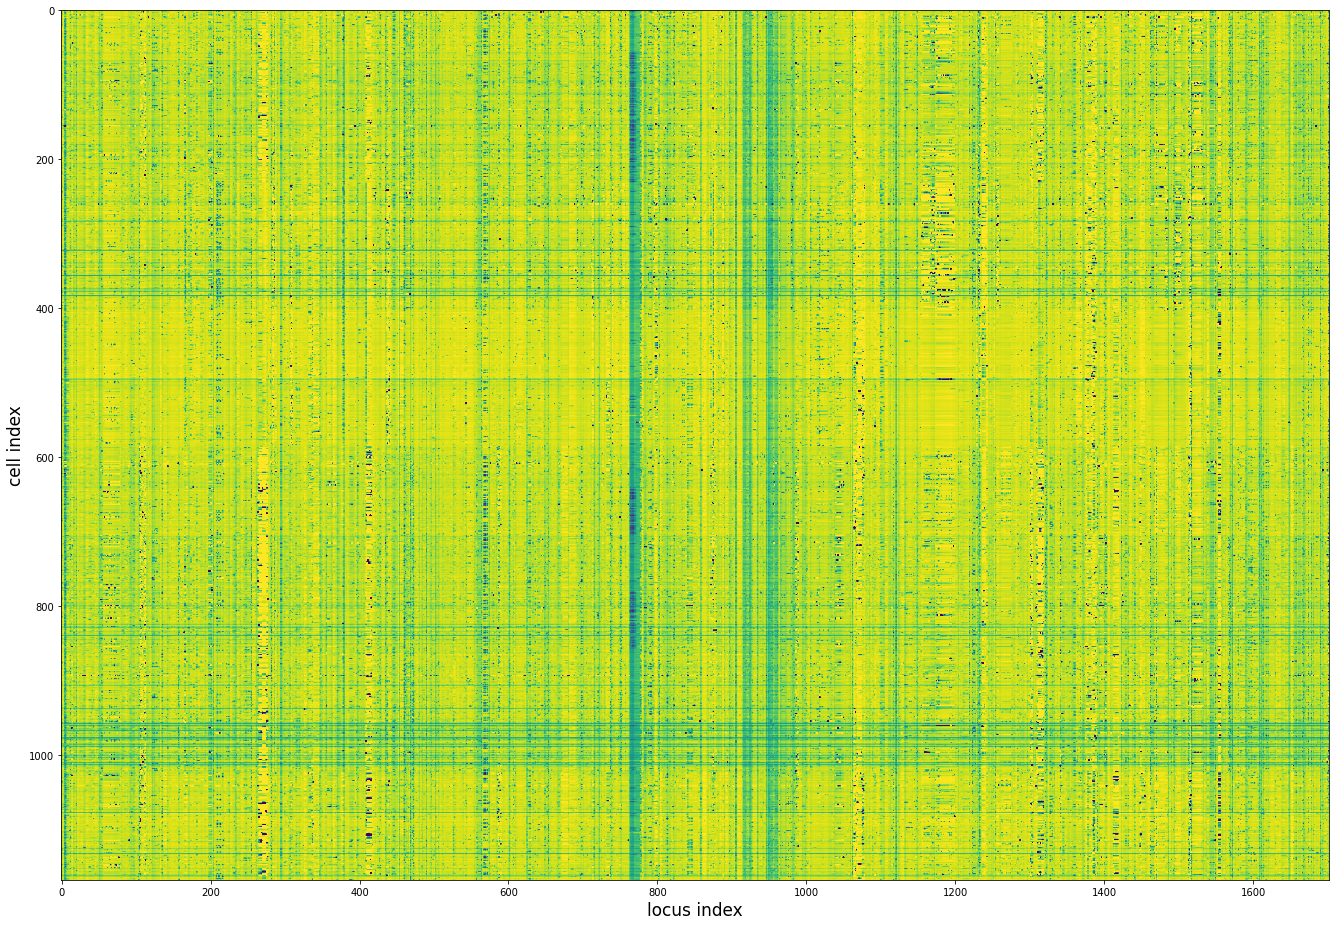

In [76]:
ref_proportion = (ref_imputed + 1) / (ref_imputed + alt_imputed + 2)

plt.figure(figsize=(24,16))
plt.imshow(ref_proportion.T, cmap = 'viridis', vmin = 0., vmax = 1.) 
# "viridis": yellow for 1, purple for 0, green/blue for 0.5 (https://matplotlib.org/3.5.1/tutorials/colors/colormaps.html)
plt.xlabel('locus index', fontsize = 17)
plt.ylabel('cell index', fontsize = 17)
plt.show()

### HMM

In [12]:
# I: initial probability
# T: transition probability (including the begin state)
# E: emission probability
# X: observation
def viterbi(I, T, E, X):
    length = X.shape[0]
    n_states = X.shape[1]
    v = np.zeros((length, n_states)) # v[j, k] = max joint probability having k at step j and emission X[i]
    
    v[0,:] = np.array([I[i] * E(i, X[0]) for i in range(n_states)])
    for j in range(1, length):
        for k in range(n_states):
            v[j,k] = E(k, X[j]) * np.max([v[j-1,l] * T(l,k) for l in range(n_states)]) # l: assumed state of previous step
    
    best_path = np.argmax(v, axis = 1)
    
    return best_path, v[-1, best_path[-1]] # second return is the max joint probability

In [13]:
transition_matrix = np.array([[0.9, 0.1],
                              [0.5, 0.5]])
def T(pre, post):
    return transition_matrix[pre, post]

In [14]:
def E(state, obs, f = 0.7, omega = 10):
    n_ref = obs[0]
    coverage = np.sum(obs)
    if state == 1: # normal (heterozygous)
        alpha = (1/2 - 2/3 * f) / omega
        beta = omega - alpha
    elif state == 2: # LOH
        alpha = f * omega
        beta = omega - alpha
    else: 
        print('\n ERROR: invalid state \n')
        return
    
    return betabinom.pmf(n_ref, coverage, alpha, beta)

In [15]:
X = np.stack((np.array(df_ref.loc['chr1',:])[0,:], np.array(df_alt.loc['chr1',:])[0,:])).T
X

array([[62,  0],
       [ 0,  0],
       [ 9,  0],
       ...,
       [23,  0],
       [ 3,  0],
       [ 3,  0]])

### Test

In [16]:
init_prob = np.array([0.5, 0.5])

transition_matrix = np.array([[0.9, 0.1],
                              [0.5, 0.5]])
def T(pre, post):
    return transition_matrix[pre, post]

emission_matrix = np.array([[0.9, 0.1],
                            [0.2, 0.8]])
def E(state, obs): 
    return emission_matrix[state, obs]

X = np.array([[0],[1]])

best_path, probability = viterbi(init_prob, T, E, X)
print(best_path)
print(probability)

[0 0]
0.04050000000000001


In [17]:
init_prob = np.array([0.5, 0.5])
transition_matrix = np.array([[0.9, 0.1],
                              [0.5, 0.5]])

states = np.zeros(1000, dtype = int)

if random() < init_prob[0]: 
    states[0] = 0
else:
    states[0] = 1

for i in range(1, 1000):
    if random() < transition_matrix[states[i-1], 0]: 
        states[i] = 0 
    else: 
        states[i] = 1

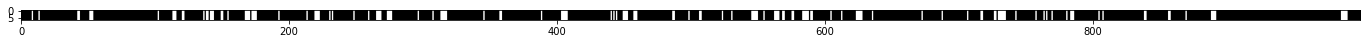

In [18]:
plt.figure(figsize=(24,16))
plt.imshow(np.stack([states for i in range(7)]), cmap = 'gray')
plt.savefig('test.png')
plt.show()